**🎮 오토인코더를 이용한 게임 추천 🎮**

# 📁 Library

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 🎲 Data

**사용자와 게임 간 상호작용에 대한 정보를 담은 데이터**
- `user_id` : 사용자 ID
- `content_id` : 게임 ID
- `game` : 게임 이름
- `view` : 사용자가 해당 게임을 구매했는지 여부

In [ ]:
# 데이터 불러오기 (interactions_full_df.csv) #
df = pd.read_csv("path")  # 경로 수정
df = df[['user_id', 'content_id', 'game', 'view']]
df.head()

,user_id,content_id,game,view
0,0,226,Alien Swarm,1
1,0,846,Cities Skylines,1
2,0,972,Counter-Strike,1
3,0,978,Counter-Strike Source,1
4,0,1125,Day of Defeat,1


In [ ]:
# 데이터 불러오기 (articles_df.csv) #
df_game = pd.read_csv("path")  # 경로 수정
df_game.head(10)

,content_id,game,total_users,total_hours
0,0,007 Legends,1,1.7
1,1,0RBITALIS,3,4.2
2,2,1... 2... 3... KICK IT! (Drop That Beat Like a...,7,27.0
3,3,10 Second Ninja,6,11.9
4,4,"10,000,000",1,4.6
5,5,100% Orange Juice,10,88.3
6,6,1000 Amps,2,2.1
7,7,12 Labours of Hercules,10,44.7
8,8,12 Labours of Hercules II The Cretan Bull,12,46.3
9,9,12 Labours of Hercules III Girl Power,6,25.6


**[ 사용자와 게임 간 상호작용 매트릭스 생성 ]**

* 각 행은 사용자를 나타냄
* 각 열은 게임을 나타냄

* 각 셀은 사용자가 해당 게임을 구매했는지 (1) 아니면 구매하지 않았는지 (0)를 나타냄

In [ ]:
users_items_matrix_df = df.pivot(
    index = 'user_id',
    columns = 'content_id',
    values = 'view'
).fillna(0)

users_items_matrix_df.head(10)

content_id,0,1,2,3,4,5,6,7,8,9,...,5103,5104,5105,5106,5107,5108,5109,5110,5111,5112
user_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
users_items_matrix_df.shape

(3757, 5113)

* 총 3,757명의 사용자와 5,113개의 게임


* 대부분의 값이 0인 매우 희소한 행렬 (sparse matrix)
  * 실제로 0이 아닌 값은 전체 값의 0.5%밖에 되지 않음

# 🧠 Model

> ⭐ **오토인코더의 주요 목표** : 입력을 유용한 표현으로 압축하여 재구성하는 것

* 초기에 상호작용 매트릭스는 희소하며 많은 NULL 값 (0으로 표시됨)을 포함
  * 재구성할 때, 오토인코더가 이러한 NULL 값에 예상되는 사용자와 해당 게임 사이의 가능한 상호작용을 채우길 희망




In [ ]:
# 상호작용 매트릭스의 값을 x 변수에 불러오기
x = users_items_matrix_df.values
print(x.shape)

(3757, 5113)


> **모델 구성**

* 인코더 : 입력 데이터를 저차원으로 압축하여 중요한 특성을 추출하는 역할 수행

* 임베딩 : 인코딩된 정보를 좀 더 의미 있는 표현 (임베딩)으로 변환
* 드롭아웃 : 과적합 방지
* 디코더 : 임베딩된 정보를 다시 원래 차원으로 풀어주는 디코딩 역할
* 예측 : 손실 함수로 MSE를 사용할 것이므로 활성화 함수로 선형 함수(Linear)를 사용하여 값을 직접 예측
  * 디코딩된 정보를 이용하여 사용자 점수를 예측하는 역할 수행

>  **입력층보다 적은 수의 뉴런를 가진 은닉층을 중간에 넣어 줌으로써 차원을 줄임**

* 이때 학습을 통해 소실된 데이터를 복원하고, 이 과정을 통해 입력 데이터의 특징을 효율적으로 응축한 새로운 출력이 나오는 원리



```
* 입력 차원 : 5,113 (게임의 수)
* 인코더 부분에서는 입력 차원을 512 차원으로 줄이는 하나의 레이어가 있음
* 임베딩은 256 차원을 가지고 있음
* 디코더 부분에서 다시 512 차원으로 돌아가고 마지막으로 원래의 5,113 차원 공간(`users_items_matrix_df.shape[1]`)으로 돌아감
```



In [ ]:
# 모델 구성 #
model = Sequential([
    Dense(units=512, activation='selu', name='enc_1', input_dim=users_items_matrix_df.shape[1]),  # 활성화 함수 (SELU)
    Dense(units=256, activation='selu', name='embeddings'),  # 임베딩
    Dropout(rate=0.8, name='dropout'),  # 과적합 방지
    Dense(units=512, activation='selu', name='dec_1'),
    Dense(units=users_items_matrix_df.shape[1], activation='linear', name='user_score_pred')  # 예측 (선형 함수)
])
model.summary()

# 모델 컴파일 #
model.compile(optimizer=Adam(lr=1e-4), loss='mse')  # 손실 함수 (MSE)

# 모델 학습 #
hist = model.fit(x, x, epochs=50, batch_size=64, shuffle=True, validation_split=0.1)  # 10%는 검증에 사용

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 enc_1 (Dense)               (None, 512)               2618368   
                                                                 
 embeddings (Dense)          (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dec_1 (Dense)               (None, 512)               131584    
                                                                 
 user_score_pred (Dense)     (None, 5113)              2622969   
                                                                 
Total params: 5504249 (21.00 MB)
Trainable params: 5504249 (21.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/50
53/53 [==============================] - 8s 123ms/step - loss: 0.0165 - val_loss: 0.0025
Epoch 2/50
53/53 [==============================] - 5s 88ms/step - loss: 0.0080 - val_loss: 0.0022
Epoch 3/50
53/53 [==============================] - 6s 113ms/step - loss: 0.0072 - val_loss: 0.0022
Epoch 4/50
53/53 [==============================] - 5s 100ms/step - loss: 0.0073 - val_loss: 0.0021
Epoch 5/50
53/53 [==============================] - 6s 121ms/step - loss: 0.0073 - val_loss: 0.0022
Epoch 6/50
53/53 [==============================] - 6s 116ms/step - loss: 0.0076 - val_loss: 0.0022
Epoch 7/50
53/53 [==============================] - 5s 90ms/step - loss: 0.0078 - val_loss: 0.0023
Epoch 8/50
53/53 [==============================] - 5s 97ms/step - loss: 0.0079 - val_loss: 0.0022
Epoch 9/50
53/53 [==============================] - 6s 113ms/step - loss: 0.0072 - val_loss: 0.0021
Epoch 10/50
53/53 [==============================] - 6s 116ms/step - loss: 0.0067 - val_loss: 0.0021
Ep

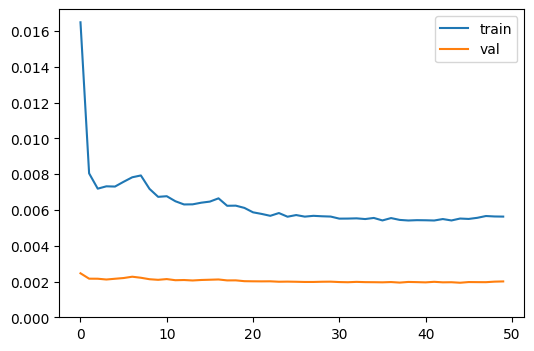

In [ ]:
#  훈련 과정에서의 손실 변화 #
plt.figure(figsize=(6, 4))
plt.plot(hist.history['loss'], label='train')  # 훈련 set
plt.plot(hist.history['val_loss'], label='val')  # 검증 set
plt.ylim(0)
plt.legend()

손실이 감소하는 경향 → 모델이 학습하고 있는 패턴을 잘 파악하고 있음 → 예측 능력 향상

# 🎮 Game Recommendation


모델 예측값을 불러오고, 초기의 값이 0이었던 부분 (즉, 사용자와 게임 간 상호작용이 없었던 부분)만 필터링

In [ ]:
new_matrix = model.predict(x) * (x == 0)  # 원래의 상호작용 매트릭스 x에서 값이 0인 부분에 대해서만 새로운 예측값을 가져옴

118/118 [==============================] - 2s 14ms/step


In [ ]:
# 모델의 예측을 바탕으로 0이었던 값들이 채워진 사용자-아이템 상호작용 매트릭스 #
new_users_items_matrix_df = pd.DataFrame(
    new_matrix,
    columns = users_items_matrix_df.columns,
    index = users_items_matrix_df.index
)
new_users_items_matrix_df.head()

content_id,0,1,2,3,4,5,6,7,8,9,...,5103,5104,5105,5106,5107,5108,5109,5110,5111,5112
user_id,,,,,,,,,,,,,,,,,,,,,
0,-0.004825,0.016362,0.007722,0.022889,0.002553,0.000797,-0.009541,-0.025799,-0.012730,-0.002123,...,-0.002760,-0.008854,-0.002752,-0.007935,-0.001911,-0.016823,-0.001955,0.006836,0.008605,-0.001400
1,-0.000465,0.016138,0.011249,0.013606,0.013137,0.011199,-0.017824,-0.011223,-0.008420,0.009125,...,-0.002640,0.024107,0.004739,-0.000213,0.004191,-0.002067,-0.003690,0.020336,0.072330,0.006144
2,-0.002915,0.018704,-0.002298,0.024898,-0.015497,-0.012904,0.005623,-0.025619,-0.020118,-0.028582,...,0.001001,-0.046423,-0.003143,0.076469,-0.004825,0.055042,0.007422,0.019277,0.093151,0.000493
3,-0.003094,0.006652,0.014560,0.008275,0.013202,0.000107,-0.010990,-0.013113,-0.016140,0.006279,...,-0.005647,0.010973,-0.002669,-0.000614,-0.000599,0.015897,-0.001888,0.014738,0.040204,0.002877
4,-0.001254,0.008378,0.014175,0.010072,0.013900,0.005331,-0.014164,-0.016082,-0.011359,0.005582,...,-0.004408,0.009902,-0.001302,0.004591,-0.000517,0.019304,-0.001672,0.012755,0.051406,0.000488


* 원래 0이었던 값들은 이제 소수로 채워짐
  * 모델은 주어진 사용자와 게임 사이의 가상적인 상호작용에 대해 알려줌

  * 이 값이 1에 가까울수록 사용자가 해당 게임을 좋아할 가능성이 높다는 것을 의미


* 이 매트릭스를 사용해 사용자에게 게임을 추천하려면, 단순히 이 값에 따라 행을 정렬하고 해당하는 게임을 얻으면 됨
  * 사용자에 대해 상호작용이 높은 순으로 정렬하여 해당하는 게임을 추천할 수 있음

  * 이를 통해 사용자에게 가장 가능성이 높은 게임을 추천할 수 있음

In [ ]:
# 사용자에 대한 추천을 생성하는 함수 #
def recommender_for_user(user_id, interact_matrix, df_content, topn = 10):
    pred_scores = interact_matrix.loc[user_id].values

    df_scores = pd.DataFrame({
        'content_id': list(users_items_matrix_df.columns),
        'score': pred_scores
    })

    df_rec = (df_scores
        .set_index('content_id')
        .join(df_content.set_index('content_id'))
        .sort_values('score', ascending=False)
        .head(topn)[['score', 'game']]
    )

    return df_rec[df_rec.score > 0]  # 점수가 0보다 큰 게임들을 기반으로 사용자에게 게임을 추천

> **특정 사용자가 이전에 플레이한 게임을 먼저 확인**

* 기존 상호작용 매트릭스를 사용하므로 모델의 예측이 아닌 실제 상호작용을 기반으로 추천

In [ ]:
recommender_for_user(user_id = 1011, interact_matrix=users_items_matrix_df, df_content=df_game)

,score,game
content_id,,
3196,1.0,Portal
4221,1.0,Team Fortress 2
2055,1.0,Half-Life 2
2058,1.0,Half-Life 2 Episode Two
2059,1.0,Half-Life 2 Lost Coast
2057,1.0,Half-Life 2 Episode One


이 사용자 (1011)가 FPS 게임을 좋아한다는 것을 고려하여, 오토인코더가 이 사용자에게 어떤 게임을 추천할 것인지 확인

 > **Autoencoder를 통해 예측된 새로운 상호작용 매트릭스를 사용하여 게임 추천**

In [ ]:
recommender_for_user(user_id=1011, interact_matrix=new_users_items_matrix_df, df_content=df_game)

,score,game
content_id,,
2056,0.379276,Half-Life 2 Deathmatch
978,0.290914,Counter-Strike Source
2062,0.233648,Half-Life Deathmatch Source
3197,0.230604,Portal 2
2457,0.212764,Left 4 Dead 2
4750,0.150384,Unturned
2064,0.149791,Half-Life Source
1879,0.143977,Garry's Mod
3792,0.137063,Sid Meier's Civilization V


오토인코더가 이 사용자에게 이전에 플레이한 게임의 에피소드와 같은 FPS 게임을 추천

**다른 유저 (1319)**
> **특정 사용자가 이전에 플레이한 게임을 먼저 확인**

In [ ]:
recommender_for_user(user_id=1319, interact_matrix=users_items_matrix_df, df_content=df_game)

,score,game
content_id,,
2661,1.0,Medieval II Total War
1752,1.0,Football Manager 2015
4272,1.0,The Bard's Tale
2662,1.0,Medieval II Total War Kingdoms
4331,1.0,The Elder Scrolls V Skyrim - Hearthfire
4330,1.0,The Elder Scrolls V Skyrim - Dragonborn
4329,1.0,The Elder Scrolls V Skyrim - Dawnguard
4328,1.0,The Elder Scrolls V Skyrim
1301,1.0,Divinity Original Sin Enhanced Edition


이 사용자는 RPG와 전략 게임을 선호하는 것으로 보임 → 모델이 이 사용자에게 어떤 게임을 추천하는지 아래에서 살펴봄

 > **Autoencoder를 통해 예측된 새로운 상호작용 매트릭스를 사용하여 게임 추천**

In [ ]:
recommender_for_user(user_id = 1319, interact_matrix=new_users_items_matrix_df, df_content=df_game)

,score,game
content_id,,
3792,0.232006,Sid Meier's Civilization V
1328,0.162486,Dota 2
3837,0.151348,Skyrim High Resolution Texture Pack
3793,0.147638,Sid Meier's Civilization V Brave New World
1667,0.124783,Fallout New Vegas
4221,0.111703,Team Fortress 2
2872,0.102562,Napoleon Total War
1668,0.101424,Fallout New Vegas Courier's Stash
1669,0.096562,Fallout New Vegas Dead Money


오토인코더는 사용자가 이미 플레이한 게임과 유사한 게임을 추천



# 📑 Conclusion
* 원래 매트릭스는 사용자가 게임을 구매했는지 여부만을 알려줬음
  * 따라서 오토인코더는 사용자에 대한 정보 (성별, 나이 등)나 게임에 대한 정보 (장르, 제작사 등)를 가지고 있지 않았음

*  추천 결과를 살펴보면, 유사한 게임 장르나 동일 제작사임을 알 수 있었음


> 💡 **오토인코더는 사용자 정보나 아이템 특징을 명시적으로 알지 못해도 유사성을 파악하고 유용한 패턴을 추출하여 추천 결과 제공**